In [61]:
# import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from numpy import loadtxt
from sklearn.preprocessing import StandardScaler, scale
from functools import partial
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
from sklearn.metrics import make_scorer
#import xgboost 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

from xgboost import plot_importance

from sklearn.ensemble import AdaBoostRegressor


In [19]:
t.cuda.is_available()

True

# Data load

In [20]:
spot_track = pd.read_csv("yearly_merged.csv")
spot_track['year'] = pd.to_datetime(spot_track['year'], format='%Y')

spot_track.set_index('year', inplace=True) 
spot_track.head()

,acousticness,danceability,duration_ms,energy,loudness,instrumentalness,liveness,speechiness,tempo,valence,popularity,key
year,,,,,,,,,,,,
1921-01-01,0.990,0.4115,178040.0,0.2205,-16.0000,0.0287,0.1655,0.04595,92.1440,0.4545,0.0,7
1922-01-01,0.994,0.4895,168053.5,0.2010,-18.6210,0.3245,0.1575,0.06665,89.6905,0.5490,0.0,10
1923-01-01,0.992,0.5765,180347.0,0.2465,-13.9605,0.2180,0.1725,0.06775,108.3805,0.6115,4.0,0
1924-01-01,0.994,0.5650,173786.5,0.3250,-13.8420,0.8440,0.1855,0.06550,118.3225,0.6995,0.0,10
1925-01-01,0.989,0.5750,179360.0,0.2390,-13.5520,0.1740,0.1550,0.07560,114.0380,0.6590,0.0,5


Text(0.5, 1.0, 'Evolution of music with time in years')

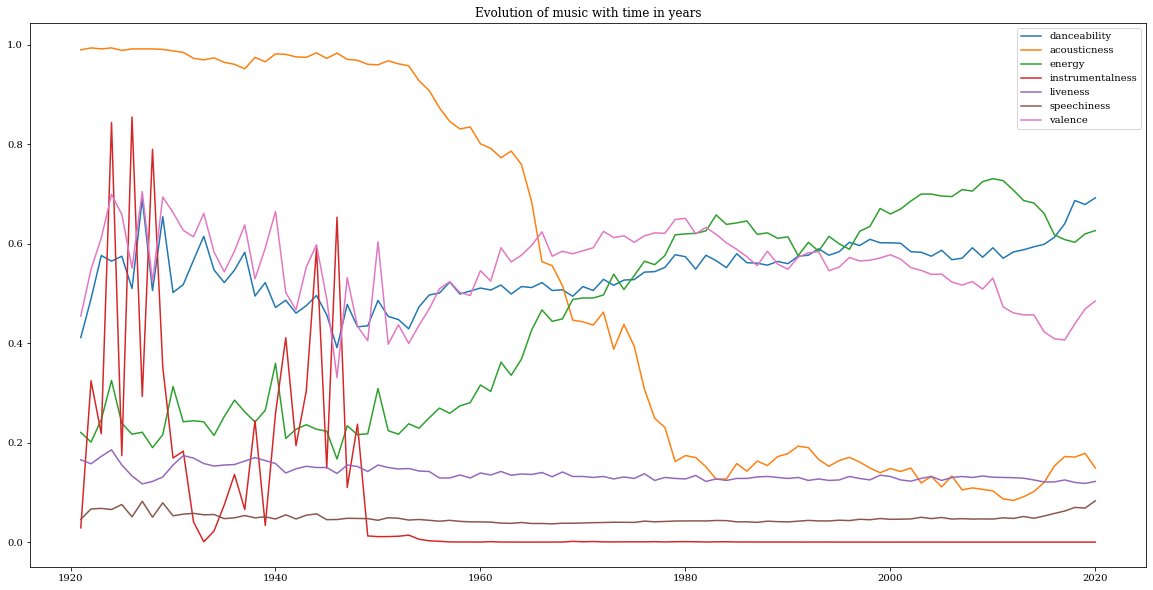

In [33]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(spot_track['danceability'], label = 'danceability')
plt.plot(spot_track['acousticness'], label = 'acousticness')
plt.plot(spot_track['energy'], label = 'energy')
plt.plot(spot_track['instrumentalness'], label = 'instrumentalness')
plt.plot(spot_track['liveness'], label = 'liveness')
plt.plot(spot_track['speechiness'], label = 'speechiness')
plt.plot(spot_track['valence'], label = 'valence')
plt.legend()
plt.title('Evolution of music with time in years')


The above graph shows how the music has evolved over time. The notion behind this study is to exploit the correlation among release date, sound properties such as instrumentalness, key, liveness,	loudness, modality etc and the popularity of the song.

# Tracks and popularity

In [36]:
all_track = pd.read_csv("cleaned_all_tracks.csv")

all_track.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,modality,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
3,0.995,"['Felix Mendelssohn', 'Vladimir Horowitz']",0.424,352600,0.1200,0,6NxAf7M8DNHOBTmEd3JSO5,0.911,6,0.0915,-19.242,0,Scherzo a capriccio: Presto,0,1928,0.0593,63.521,0.2660,1928
4,0.956,"['Franz Liszt', 'Vladimir Horowitz']",0.444,136627,0.1970,0,6O0puPuyrxPjDTHDUgsWI7,0.435,11,0.0744,-17.226,1,"Valse oubliée No. 1 in F-Sharp Major, S. 215/1",0,1928,0.0400,80.495,0.3050,1928


The idea is to use XGBoost to predict the popularity the song might achieve given the name of the artist, year and properties of the music. 

In [51]:
all_track.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,modality,popularity,speechiness,tempo,valence,year
count,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000,163619.000000
mean,0.491037,0.537947,224077.662655,0.496445,0.075022,0.161260,5.200881,0.203051,-11.130845,0.710785,32.390053,0.074629,117.407645,0.535702,1978.202752
std,0.377613,0.174017,82515.156585,0.266346,0.263427,0.308618,3.506395,0.173347,5.548305,0.453399,21.328777,0.080549,30.498202,0.262550,25.245442
min,0.000000,0.055100,15462.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-55.000000,0.000000,0.000000,0.000000,30.946000,0.000000,1921.000000
25%,0.090400,0.418000,172373.000000,0.275000,0.000000,0.000000,2.000000,0.097800,-14.063000,0.000000,14.000000,0.034700,94.007000,0.325000,1958.000000
50%,0.487000,0.546000,208573.000000,0.492000,0.000000,0.000227,5.000000,0.133000,-10.259000,1.000000,34.000000,0.044500,115.084000,0.547000,1979.000000
75%,0.887000,0.664000,260757.500000,0.716000,0.000000,0.085800,8.000000,0.257000,-7.008000,1.000000,49.000000,0.071400,136.014000,0.755000,2000.000000
max,0.996000,0.988000,595227.000000,1.000000,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,100.000000,0.659000,244.091000,1.000000,2020.000000


# Data split

In [47]:
n = len(all_track)
test_n = round(n*0.15)
val_n = round(n*0.15)
train_n = n-val_n-test_n

In [57]:
feature = all_track.iloc[:, [0,2,3,4,5,7,8,9,10,11,15,16,17,18]]
target = all_track.iloc[:, [13]]

In [58]:

X_train = feature[0:train_n]
y_train = target[0:train_n]
# 5 days for validation
X_val = feature[train_n:train_n+val_n]
y_val = target[train_n:train_n+val_n]
#last two weeks test
X_test = feature[train_n+val_n: ] 
y_test = target[train_n+val_n:]
X_train_val = feature[:train_n+val_n]
y_train_val = target[:train_n+val_n]



In [59]:
import warnings
warnings.filterwarnings("ignore")
model = XGBRegressor() #parameters selected by hyperparameter optimization
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [67]:
from sklearn.metrics import make_scorer
def train_xgb(params, X_train, y_train, X_test):

    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    model = XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"], tree_method = 'gpu_hist')

    result = model.fit(X_train, 
                       y_train.values.ravel(),
                        eval_set=[(X_train, y_train.values.ravel())],
                        early_stopping_rounds=50,
                        verbose=False)
    pred = model.predict(X_test)
    return(pred)
 
def validate(params,X_train,y_train,X_test,y_test):
    prediction = []
    i = 1
    n = round(int(len(y_test)/168))
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])
    model = XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])
   
    prediction.extend(train_xgb(params, X_train, y_train, X_test))

    mse = mean_squared_error(prediction,y_test)
    maape = mape(prediction,y_test)
    print(maape)
    print(params)
    return {
        "loss": maape,
        "status": STATUS_OK,
        "model": model
    }

    
def optimize_xgb(X_train, y_train,X_test, y_test, max_evals=10):
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 1, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(validate, 
                           X_train=X_train, 
                           y_train=y_train,
                           X_test = X_test,
                           y_test = y_test)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials



In [68]:
best, trials = optimize_xgb(X_train, y_train, X_val, y_val, max_evals=20)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001969 seconds
INFO:hyperopt.tpe:TPE using 0 trials


0.6648059167876816                                    
{'gamma': 69.0, 'learning_rate': 0.5520986437128219, 'max_depth': 7.0, 'n_estimators': 640.0, 'subsample': 0.9848445005728474}
  5%|▌         | 1/20 [00:08<02:50,  8.95s/trial, best loss: 0.6648059167876816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.664806


0.34295928032004036                                                             
{'gamma': 53.0, 'learning_rate': 0.828325508223106, 'max_depth': 1.0, 'n_estimators': 870.0, 'subsample': 0.8119276793831827}
 10%|█         | 2/20 [00:11<01:32,  5.15s/trial, best loss: 0.34295928032004036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.342959


0.3264118214985015                                                               
{'gamma': 92.0, 'learning_rate': 0.047063224583406345, 'max_depth': 4.0, 'n_estimators': 560.0, 'subsample': 0.8664678430131172}
 15%|█▌        | 3/20 [00:14<01:08,  4.01s/trial, best loss: 0.3264118214985015] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.326412


0.2851143399017548                                                              
{'gamma': 81.0, 'learning_rate': 0.033231793596111066, 'max_depth': 1.0, 'n_estimators': 250.0, 'subsample': 0.9778697639469492}
 20%|██        | 4/20 [00:14<00:43,  2.75s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002010 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.285114


0.33738428504025786                                                             
{'gamma': 32.0, 'learning_rate': 0.013142873206909277, 'max_depth': 5.0, 'n_estimators': 210.0, 'subsample': 0.9595657145371018}
 25%|██▌       | 5/20 [00:16<00:33,  2.25s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.285114


0.3942260493504536                                                              
{'gamma': 29.0, 'learning_rate': 0.44011738406947054, 'max_depth': 6.0, 'n_estimators': 220.0, 'subsample': 0.9590683628524731}
 30%|███       | 6/20 [00:18<00:30,  2.19s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.285114


0.613149846171393                                                               
{'gamma': 12.0, 'learning_rate': 2.246366272386285, 'max_depth': 7.0, 'n_estimators': 440.0, 'subsample': 0.9914642863395731}
 35%|███▌      | 7/20 [00:19<00:22,  1.73s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.285114


0.34630091325745305                                                             
{'gamma': 58.0, 'learning_rate': 0.030814724106909882, 'max_depth': 8.0, 'n_estimators': 250.0, 'subsample': 0.9243339576717468}
 40%|████      | 8/20 [00:25<00:37,  3.16s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.285114


0.5760951710697971                                                              
{'gamma': 51.0, 'learning_rate': 0.03722437107477288, 'max_depth': 8.0, 'n_estimators': 240.0, 'subsample': 0.9599959632309752}
 45%|████▌     | 9/20 [00:31<00:44,  4.01s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.285114


0.4354470125241779                                                              
{'gamma': 62.0, 'learning_rate': 0.2627299404813552, 'max_depth': 6.0, 'n_estimators': 530.0, 'subsample': 0.826438871387724}
 50%|█████     | 10/20 [00:36<00:42,  4.25s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002069 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.285114


0.4290595046271375                                                               
{'gamma': 59.0, 'learning_rate': 0.17871663487138864, 'max_depth': 6.0, 'n_estimators': 700.0, 'subsample': 0.9435464921975278}
 55%|█████▌    | 11/20 [00:42<00:44,  4.98s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.285114


1.992072569280074                                                                
{'gamma': 19.0, 'learning_rate': 1.4914884397790744, 'max_depth': 7.0, 'n_estimators': 440.0, 'subsample': 0.8775995378106871}
 60%|██████    | 12/20 [00:49<00:44,  5.56s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.285114


0.5382621667579462                                                               
{'gamma': 36.0, 'learning_rate': 0.786693349851652, 'max_depth': 4.0, 'n_estimators': 790.0, 'subsample': 0.9512751640794357}
 65%|██████▌   | 13/20 [00:53<00:35,  5.07s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.285114


0.34672863353210814                                                              
{'gamma': 58.0, 'learning_rate': 0.17740546819059125, 'max_depth': 1.0, 'n_estimators': 370.0, 'subsample': 0.9960913031424805}
 70%|███████   | 14/20 [00:54<00:23,  3.91s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.285114


0.6127873560382702                                                               
{'gamma': 28.0, 'learning_rate': 2.446196072679721, 'max_depth': 5.0, 'n_estimators': 100.0, 'subsample': 0.8110699955920757}
 75%|███████▌  | 15/20 [00:55<00:14,  2.87s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.285114


0.43884880770157847                                                              
{'gamma': 1.0, 'learning_rate': 0.06383556092269532, 'max_depth': 7.0, 'n_estimators': 920.0, 'subsample': 0.869847874060795}
 80%|████████  | 16/20 [01:09<00:25,  6.30s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001707 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.285114


0.33761465037737887                                                              
{'gamma': 46.0, 'learning_rate': 0.05281823352733815, 'max_depth': 2.0, 'n_estimators': 590.0, 'subsample': 0.9725383065212393}
 85%|████████▌ | 17/20 [01:11<00:15,  5.17s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.285114


0.3760155955912065                                                               
{'gamma': 32.0, 'learning_rate': 0.6192412843218715, 'max_depth': 2.0, 'n_estimators': 160.0, 'subsample': 0.8179654187789637}
 90%|█████████ | 18/20 [01:12<00:07,  3.83s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.285114


0.3935554557132548                                                               
{'gamma': 91.0, 'learning_rate': 0.1978378999429436, 'max_depth': 4.0, 'n_estimators': 440.0, 'subsample': 0.8923980710877477}
 95%|█████████▌| 19/20 [01:14<00:03,  3.35s/trial, best loss: 0.2851143399017548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.285114


0.616012929426071                                                                
{'gamma': 31.0, 'learning_rate': 0.9821394536481848, 'max_depth': 4.0, 'n_estimators': 530.0, 'subsample': 0.8564310837370315}
100%|██████████| 20/20 [01:17<00:00,  3.87s/trial, best loss: 0.2851143399017548]

    Best parameters:
        learning_rate: 0.033231793596111066 
        n_estimators: 250.0
        max_depth: 1.0
        sub_sample: 0.9778697639469492
        gamma: 81.0
    


In [69]:
best

{'gamma': 81.0,
 'learning_rate': 0.033231793596111066,
 'max_depth': 1.0,
 'n_estimators': 250.0,
 'subsample': 0.9778697639469492}

In [70]:

def xgboost_predict(X_train,y_train):
    #model = XGBRegressor(learning_rate = 0.12237951124850033 ,gamma = 31, max_depth = 1, n_estimators = 170, subsample = 0.8273731929652296, tree_method = 'gpu_hist')
    model = XGBRegressor(learning_rate = 0.033231793596111066 ,gamma = 81, max_depth = 1, n_estimators = 250, subsample = 0.9778697639469492, tree_method = 'gpu_hist')
    model.fit(X_train, y_train)
    #pred = model.predict(X_test)
    return(model)

mod = xgboost_predict(X_train_val, y_train_val)
pred = []
for i in range(len(X_test)):
    X_t = X_test[i:i+1]
    pred.extend(mod.predict(X_t))
    

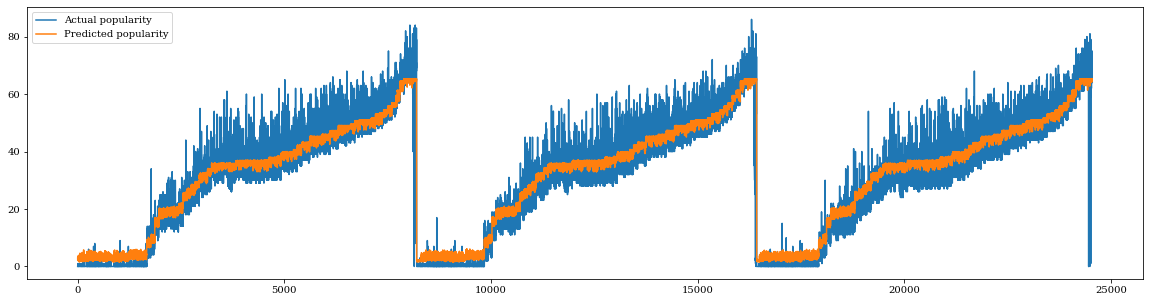

In [84]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.plot(y_test.values, label = 'Actual popularity')
plt.plot(pred, label= 'Predicted popularity')
plt.legend()

In [82]:
print('Mean absolute error of prediction is ',mae(y_test.values,pred))

Mean absolute error of prediction is  22.136964737893532


The above designed model is able to predict the popularity of a song by considering its year of release and sound properties sound properties such as instrumentalness, key, liveness,	loudness, modality etc.
The result obtained in the above graphs showcases that XGBoost model is able to learn and predict the correlation between the sound properties and its popularity. This model can be used to determine how popular an upcoming song might be which is crucial to determine the financial future of the song and also the artist.